# Example 1: running GLMsingle on an example session from the Natural Scenes Dataset; comparing voxel reliability across versions

In [199]:
import numpy as np
import os
from os.path import join, exists
import sys
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import glmsingle
from glmsingle.glmsingle import GLM_single
import time
import urllib.request
import importlib
importlib.reload(glmsingle)
import copy

# Step 1: load fMRI dataset

In [232]:
homedir = f'/lab_data/tarrlab/jacobpri/GLMsingle'

datadir = join(homedir,'examples','datasets')
os.makedirs(datadir,exist_ok=True)

datafn = join(datadir,'nsdcoreexampledataset3.mat')

In [233]:
if not exists(datafn):
    
    print(f'Downloading example dataset and saving to:\n{datafn}')
    
    # NSD core experiment, subject 1, session 1, one slice of the fMRI volume. 750 trials total
    dataurl = 'https://www.dropbox.com/s/68lcqbdr00jyook/nsdcoreexampledataset3.mat?dl=1'
    
    #file = urllib.urlretrieve()
    urllib.request.urlretrieve(dataurl, datafn)
    
# load it
X = sio.loadmat(datafn)

stimdur = X['stimdur'][0][0]
tr = X['tr'][0][0]


/lab_data/tarrlab/jacobpri/GLMsingle/examples/datasets/nsdcoreexampledataset3.mat


In [234]:
data = []
design = []

for r in range(len(X['data'][0])):
    data.append(X['data'][0,r])
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))

# visualize data and design matrix

In [235]:
print(f'data has {len(data)} runs')
print(f'shape of data from each run is: {data[0].shape}')
print(f'XYZ dimensionality is: {data[0].shape[:3]} (one slice only)')
print(f'n = {data[0].shape[3]} TRs per run')
print(f'type of data is: {type(data[0][0,0,0,0])}')

data has 12 runs
shape of data from each run is: (145, 186, 1, 300)
XYZ dimensionality is: (145, 186, 1) (one slice only)
n = 300 TRs per run
type of data is: <class 'numpy.float32'>


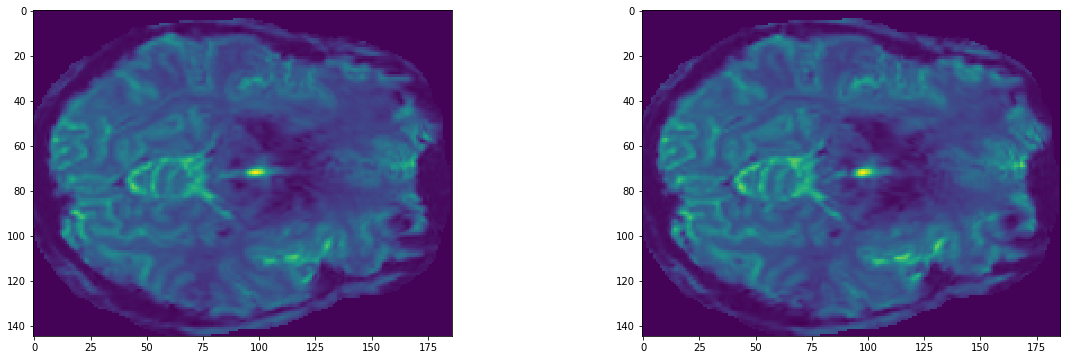

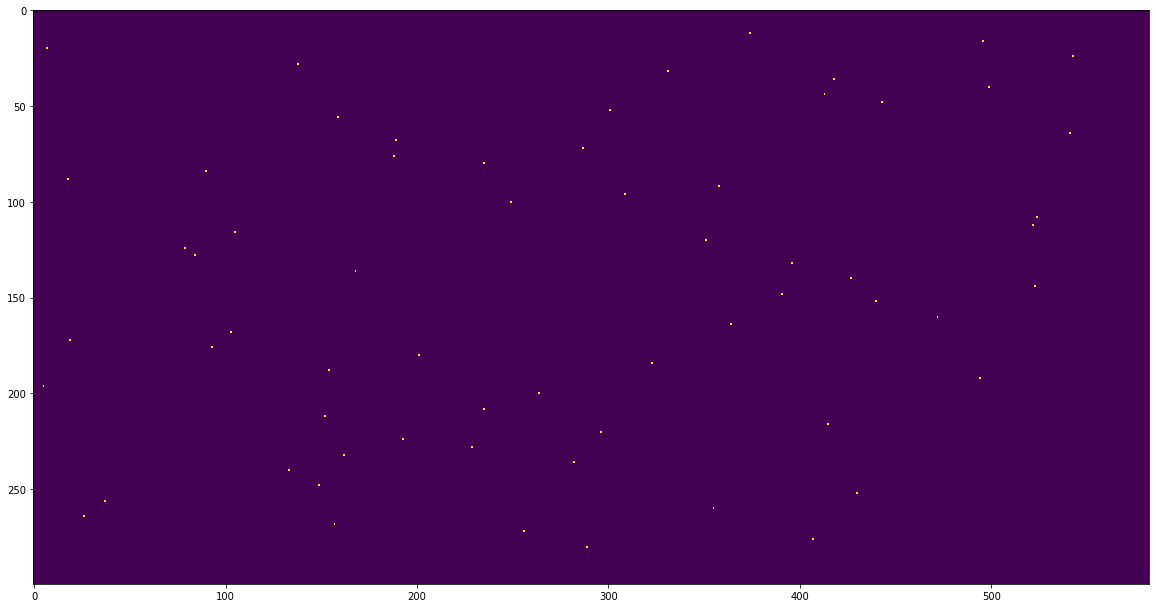

In [236]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(data[0][:,:,0,0])
plt.subplot(122)
plt.imshow(data[10][:,:,0,0])

plt.figure(figsize=(20,20))
plt.imshow(design[0])

# Step 2: Run baseline GLM (canonical HRF and no optimizations) using GLMsingle

In [238]:
outputdir = join(homedir,'examples','example1outputs_assumehrf_s3')

opt = dict()
opt['wantlibrary'] = 0
opt['wantglmdenoise'] = 0
opt['wantfracridge'] = 0
opt['wantfileoutputs'] = [1,1,0,0]
opt['wantmemoryoutputs'] = [1,1,0,0]

start_time = time.time()
gst = GLM_single(opt)

print(gst.params)

{'wantlibrary': 0, 'wantglmdenoise': 0, 'wantfracridge': 0, 'wantfileoutputs': [1, 1, 0, 0], 'wantmemoryoutputs': [1, 1, 0, 0], 'numforhrf': 50, 'hrfthresh': 0.5, 'hrffitmask': 1, 'R2thresh': 0, 'hrfmodel': 'optimise', 'n_jobs': 1, 'n_pcs': 10, 'n_boots': 100, 'extra_regressors': False, 'chunklen': 45000, 'wantparametric': 0, 'wantpercentbold': 1, 'wantlss': 0, 'brainthresh': [99.0, 0.1], 'brainR2': [], 'brainexclude': False, 'pcR2cutoff': [], 'pcR2cutoffmask': 1, 'pcstop': 1.05, 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]), 'wantautoscale': 1, 'seed': 1621491335.6248696, 'suppressoutput': 0, 'lambda': 0}


In [239]:
# run GLMsingle
results_assumehrf = gst.fit(
   design,
   data,
   stimdur,
   tr,
   outputdir=outputdir)

elapsed_time = time.time() - start_time
print(
    'elapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)


*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.


*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs_assumehrf_s3/TYPEA_ONOFF.npy. ***



/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:876: RuntimeWarning: divide by zero encountered in true_divide
  con = 1/np.abs(results['meanvol']) * 100
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:879: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betas'])
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:881: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betasmd'])
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:883: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betasse'])
chunks:   0%|          | 0/1 [00:00<?, ?it/s]

*** Setting brain R2 threshold to 1.2939225743738558 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:876: RuntimeWarning: divide by zero encountered in true_divide
  con = 1/np.abs(results['meanvol']) * 100
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:879: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betas'])
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:881: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betasmd'])
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:883: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betasse'])
chunks: 100%|██████████| 1/1 [00:22<00:00, 22.37s/it]



*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs_assumehrf_s3/TYPEB_FITHRF.npy. ***

*** All model types done ***

*** return model types in results ***

elapsed time:  00:00:38


In [ ]:
# Step 3: Visualize baseline GLM outputs

In [240]:
R2 = results_assumehrf['typea']['onoffR2'].reshape((145,186))

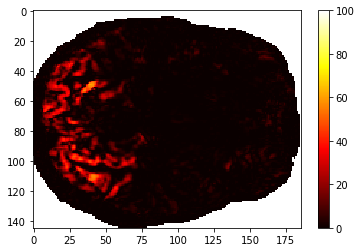

In [241]:
plt.imshow(R2,aspect='auto',clim=(0,100),cmap='hot')
plt.colorbar()

In [242]:
betas = stats.zscore(results_assumehrf['typeb']['betasmd'].reshape((145,186,1,750)),axis=3)

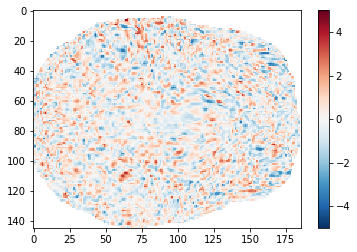

In [243]:
plt.imshow(betas[:,:,0,78],aspect='auto',clim=(-5,5),cmap='RdBu_r')
plt.colorbar()

In [ ]:
# Step 4: Run GLMsingle with optimizations (library of HRFs, GLMdenoise, fractional ridge regression)

In [244]:
outputdir = join(homedir,'examples','example1outputs_fullGLMsingle_s3')

opt = dict()
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [0,0,0,1]

start_time = time.time()
gst = GLM_single(opt)

print(gst.params)

{'wantlibrary': 1, 'wantglmdenoise': 1, 'wantfracridge': 1, 'wantfileoutputs': [1, 1, 1, 1], 'wantmemoryoutputs': [0, 0, 0, 1], 'numforhrf': 50, 'hrfthresh': 0.5, 'hrffitmask': 1, 'R2thresh': 0, 'hrfmodel': 'optimise', 'n_jobs': 1, 'n_pcs': 10, 'n_boots': 100, 'extra_regressors': False, 'chunklen': 45000, 'wantparametric': 0, 'wantpercentbold': 1, 'wantlss': 0, 'brainthresh': [99.0, 0.1], 'brainR2': [], 'brainexclude': False, 'pcR2cutoff': [], 'pcR2cutoffmask': 1, 'pcstop': 1.05, 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]), 'wantautoscale': 1, 'seed': 1621491335.6248696, 'suppressoutput': 0, 'lambda': 0}


In [245]:
# run GLMsingle
results_GLMsingle = gst.fit(
   design,
   data,
   stimdur,
   tr,
   outputdir=outputdir)

elapsed_time = time.time() - start_time
print(
    'elapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)


*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.


*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs_fullGLMsingle_s3/TYPEA_ONOFF.npy. ***



/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:876: RuntimeWarning: divide by zero encountered in true_divide
  con = 1/np.abs(results['meanvol']) * 100
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:879: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betas'])
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:881: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betasmd'])
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:883: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betasse'])
chunks:   0%|          | 0/1 [00:00<?, ?it/s]

*** Setting brain R2 threshold to 1.2939225743738558 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:876: RuntimeWarning: divide by zero encountered in true_divide
  con = 1/np.abs(results['meanvol']) * 100
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:879: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betas'])
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:881: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betasmd'])
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:883: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betasse'])
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/glmsingle/ols/glm_estimatemodel.py:876: RuntimeWarning: divide by zero encountered in true_divide
  con = 1/np.abs(results['meanvol']) * 100
/home/jacobpri/Gating/myenv/lib/


*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs_fullGLMsingle_s3/TYPEB_FITHRF.npy. ***

*** DETERMINING GLMDENOISE REGRESSORS ***



chunks:   0%|          | 0/1 [00:00<?, ?it/s]

*** CROSS-VALIDATING DIFFERENT NUMBERS OF REGRESSORS ***



/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-

UnboundLocalError: local variable 'nx' referenced before assignment

In [ ]:
# Step 5: Get indices of betas from repeated images; compare voxel split-half reliability across beta versions

In [218]:
results_GLMsingle = np.load(join(outputdir,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

In [219]:
betas = stats.zscore(np.squeeze(results_GLMsingle['betasmd'].reshape(145,186,750)),axis=2)

In [220]:
betas.shape

(145, 186, 750)

In [221]:
cond_idx = []
for des in design:
    for i in range(des.shape[0]):
        if np.sum(des[i,:]) > 0:
            cond_idx.append(np.argwhere(des[i,:] == 1)[0,0])
cond_idx = np.array(cond_idx)

unique_conds, cond_counts = np.unique(cond_idx,return_counts=True)

In [228]:
sum(cond_counts==3)

31

In [222]:
print(rep_conds)

[ 13  16  18  21  23  26  28  35  36  42  43  47  54  56  58  61  64  65
  66  73  81  86  93  94  98 106 111 118 120 129 131 133 134 135 137 139
 142 143 145 151 154 156 159 161 173 178 185 186 192 203 204 207 211 215
 221 227 233 235 239 240 245 250 259 264 269 273 276 279 280 286 290 291
 298 299 306 309 310 317 318 329 340 348 357 364 366 369 370 372 375 376
 377 378 383 385 393 403 408 417 420 424 425 428 429 430 431 442 445 446
 447 460 461 463 468 469 482 492 495 504 508 513 514 522 524 529 534 537
 550 554 555 556 560 563 564 566 574 578]


In [223]:
rep_conds = unique_conds[cond_counts > 1]

rep_betas = dict()

for cond in rep_conds:
    rep_betas[cond] = []
    idxs = np.argwhere(cond_idx == cond)
    for idx in idxs:
        rep_betas[cond].append(np.squeeze(betas[:,:,idx]))
    
    # if a third rep is available, average with the second rep
    if len(rep_betas[cond]) > 2:
        rep_betas[cond][1] = np.nanmean(np.stack(rep_betas[cond][1:],axis=2),axis=2)
        rep_betas[cond] = rep_betas[cond][:2]

/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


In [224]:
splitA = []
splitB = []

for cond in rep_conds:
    splitA.append(rep_betas[cond][0])
    splitB.append(rep_betas[cond][1])
    
splitA = np.stack(splitA,axis=2)
splitB = np.stack(splitB,axis=2)

print(splitA.shape)

(145, 186, 136)


In [225]:
voxel_reliabilities = np.empty(splitA.shape[:2])

for i in range(splitA.shape[0]):
    for j in range(splitB.shape[1]):
        vox_splitA = splitA[i,j]
        vox_splitB = splitB[i,j]
        goodidx = np.logical_and(np.logical_not(np.isnan(vox_splitA)),
                                 np.logical_not(np.isnan(vox_splitB)))
        
        r = np.corrcoef(vox_splitA[goodidx],
                        vox_splitB[goodidx])[1,0]
        
        voxel_reliabilities[i,j] = r

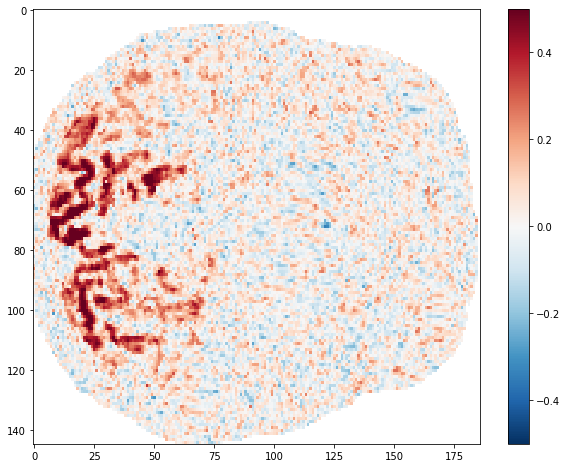

In [226]:
plt.figure(figsize=(10,8))
plt.imshow(voxel_reliabilities,aspect='auto',cmap='RdBu_r',clim=(-0.5,0.5))
plt.colorbar()